## Baysian Classification and Naive Bayes for genre classification using lyrics 

In this notebook we look at the problem of classifying songs to three genres (rap, rock and country) based on a simple binary bag of words representation. First we load the data and then we take a look at it. Using our implementation of discrete random variables we generate new random songs. Finally we show how classification can be performed using Bayes Rule. The data comes for the lyrics of songs from the Million Song DataSet and was created for an assignment in my course on MIR. 

The data layout and the way the classifier is implemented is not general and not optimal but done for pedagogical purposes. 


(1000, 30) (1000, 30) (1000, 30)


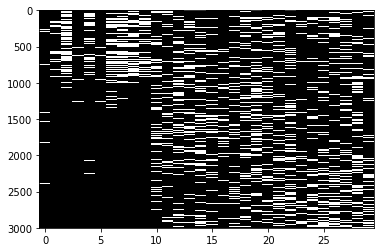

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pickle 
import numpy as np


# load some lyrics bag of words data, binarize, separate matrix rows by genre 
data = np.load('data.npz')
a = data['arr_0']
a[a > 0] = 1
labels = np.load('labels.npz')
labels = labels['arr_0']
dictionary = pickle.load(open('dictionary.pck','rb'), encoding='latin1')
word_indices = [  41, 1465,  169,  217, 1036,  188,  260,  454,  173,  728,  163,
        151,  107,  142,   90,  141,  161,  131,   86,   73,  165,  133,
         84,  244,  153,  126,  137,  119,   80,  224]
words = [dictionary[r] for r in word_indices]

# binary row vectors separate by genre 
ra_rows = a[0:1000,:]
ro_rows = a[1000:2000,:]
co_rows = a[2000:3000,:] 
print(ra_rows.shape, ro_rows.shape, co_rows.shape)


plt.imshow(a, aspect='auto', cmap='gray')


Let's calculate the word probability vector for each genre and then look at the most probable words for each genre in our data as well as how particular songs are represented as bag of words 

In [3]:
# calculate word counts for each genre 
word_probs_ra = (ra_rows.sum(axis=0).astype(float) + 1.0) / 1001.
word_probs_ro = (ro_rows.sum(axis=0).astype(float) + 1.0) / 1001.
word_probs_co = (co_rows.sum(axis=0).astype(float) + 1.0) / 1001.

print(word_probs_ro)
words

[ 0.03796204  0.00699301  0.04595405  0.03196803  0.00699301  0.02697303
  0.08791209  0.04095904  0.02297702  0.01898102  0.1998002   0.18981019
  0.22077922  0.1998002   0.30869131  0.19180819  0.18581419  0.22377622
  0.23776224  0.32067932  0.15384615  0.15784216  0.26473526  0.06393606
  0.16083916  0.17882118  0.14785215  0.1968032   0.26073926  0.11088911]


['de',
 'niggaz',
 'ya',
 'und',
 'yall',
 'ich',
 'fuck',
 'shit',
 'yo',
 'bitch',
 'end',
 'wait',
 'again',
 'light',
 'eye',
 'noth',
 'lie',
 'fall',
 'our',
 'away',
 'gone',
 'good',
 'night',
 'blue',
 'home',
 'long',
 'littl',
 'well',
 'heart',
 'old']

In [5]:
#let's look at the bag of words for three particular songs 
track_id = 20
print("RAP for trackid:",[words[i] for i,r in enumerate(ra_rows[track_id]) if r==1])
print("ROCK for trackid:",[words[i] for i,r in enumerate(ro_rows[track_id]) if r==1])
print("COUNTRY for trackid:",[words[i] for i,r in enumerate(co_rows[track_id]) if r==1])

RAP for trackid: ['ya', 'yo', 'end', 'wait', 'our', 'old']
ROCK for trackid: ['again', 'light', 'fall', 'our', 'away', 'good', 'night', 'blue', 'long', 'well']
COUNTRY for trackid: ['long', 'well', 'old']


In [6]:
# let's look at the k most probable words for each genre 
k = 10 
[[words[x] for x in np.argpartition(word_probs_ra, -k)[-k:]],
 [words[x] for x in np.argpartition(word_probs_ro, -k)[-k:]],
 [words[x] for x in np.argpartition(word_probs_co, -k)[-k:]]]

#word_probs_ra
 

[['night',
  'eye',
  'good',
  'ya',
  'yall',
  'fuck',
  'littl',
  'shit',
  'yo',
  'bitch'],
 ['well',
  'light',
  'end',
  'again',
  'night',
  'away',
  'our',
  'fall',
  'heart',
  'eye'],
 ['home',
  'eye',
  'night',
  'good',
  'away',
  'long',
  'littl',
  'well',
  'heart',
  'old']]

In [13]:
funny_list = ['a','b','c']
print(funny_list)

for (i,w) in enumerate(funny_list): 
    print(i,w)

['a', 'b', 'c']
0 a
1 b
2 c


Now let's generate some random songs represented as bag of words using the calculated word probabilities. 


In [8]:
print('Random rap', [w for (i,w) in enumerate(words) if np.greater(word_probs_ra, np.random.rand(30))[i]])
print('Random rock', [w for (i,w) in enumerate(words) if np.greater(word_probs_ro, np.random.rand(30))[i]])
print('Random country', [w for (i,w) in enumerate(words) if np.greater(word_probs_co, np.random.rand(30))[i]])


Random rap ['niggaz', 'fuck', 'good', 'littl']
Random rock ['wait', 'eye', 'lie', 'night']
Random country ['eye', 'away', 'night', 'old']


Now let's look at classifying songs using a naive Bayes multinomial classifier. 
We simply calculate the likelihood for each genre independently by taking the products of the 
genre dependent word probabilities. The genere with the highest likelihood is selected as the predicted 
class. 


In [11]:
# calcuate likelihood separately for each word 
# using naive bayes assumption and multiply 
# typically a sum of log-likelihoods is used 
# rather than a multiplication. 
def likelihood(test_song, word_probs_for_genre): 
    probability_product = 1.0 
    for (i,w) in enumerate(test_song): 
        if (w==1): 
            probability = word_probs_for_genre[i]
        else: 
            probability = 1.0 - word_probs_for_genre[i]
        probability_product *= probability 
    return probability_product 

def predict(test_song): 
    scores = [likelihood(test_song, word_probs_ra), 
             likelihood(test_song, word_probs_ro),
             likelihood(test_song, word_probs_co)]
    labels = ['rap', 'rock', 'country']
    return labels[np.argmax(scores)]

def predict_set(test_set, ground_truth_label): 
    score = 0 
    for r in test_set: 
        if predict(r) == ground_truth_label: 
            score += 1
    # convert to percentage 
    return score / 10.0 

# predict a random country track 
track_id = np.random.randint(1000)
print("Random track id", track_id)
test_song = co_rows[track_id]
print(predict(test_song))

Random track id 634
rock


In [12]:
# Let's evaluate how well our classifier does on the training set 
# A more proper evaluation would utilize cross-validation 

print("Rap accuracy% = ", predict_set(ra_rows, 'rap'))
print("Rock accuracy% = ", predict_set(ro_rows, 'rock'))
print("Country accuracy% = ", predict_set(co_rows, 'country'))
            

Rap accuracy% =  74.9
Rock accuracy% =  63.1
Country accuracy% =  70.9


In [13]:
test_song = co_rows[track_id]


In [17]:
print(test_song)

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0]


In [14]:
scores = [likelihood(test_song, word_probs_ra), 
             likelihood(test_song, word_probs_ro),
             likelihood(test_song, word_probs_co)]

In [15]:
print(scores)


[4.8732060381465775e-09, 1.0047409781053687e-06, 9.7174306979571186e-07]
